In [1218]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()  # for plot styling
import matplotlib.pyplot as plt
pd.options.mode.copy_on_write = True 
import datetime 

# Analisis Exploratorio de datos de Turismo en Argentina

##  Datos

### Fuente Datos Argentina datos.gob.ar

1) **pernoctes_por_localidad_segun_residencia.csv**: Pernoctaciones en hoteles y parahoteles por localidad de destino según tipo de residencia Cantidad de noches en hoteles y parahoteles por localidad de destino según tipo de residencia en formato de series de tiempo
https://datos.gob.ar/dataset/turismo_93db331e-6970-4d74-8589-c1223ac9c282/archivo/turismo_7b6ba47f-4aa9-4743-96be-d0e6157cfc5e


2) **coordenadas.csv**: valores de latitud y longitud de localidades Argentinas

3) **puna_base_agregada.csv**: Base agrupada del Padrón Único Nacional de Alojamiento (PUNA):
Base agrupada del Padrón Único Nacional de Alojamiento con datos de establecimientos, unidades, habitaciones y plazas de alojamientos turísticos.https://datos.gob.ar/dataset/turismo-padron-unico-nacional-alojamiento/archivo/turismo_01d23e57-ba58-48ed-a1c9-e1604ae78a1d


### 1. pernoctes_por_localidad_segun_residencia.csv
***

In [1219]:
pernoctes=pd.read_csv('../Datos/pernoctes_por_localidad_segun_residencia.csv')

In [1220]:
pernoctes.head(3)

,indice_tiempo,localidad,origen_pernoctes,pernoctes,observaciones
0,2018-01-01,Bahía Blanca,Total,16619.0,NaN
1,2018-01-01,Bahía Blanca,Residentes,15784.0,NaN
2,2018-01-01,Bahía Blanca,No residentes,835.0,NaN


### 2. coordenadas.csv
***

In [1221]:
coord_loc=pd.read_csv('../Datos/coordenadas.csv', encoding='latin')

In [1222]:
coord_loc.head(3)

,Localidad,Latitud,Longitud
0,Bahía Blanca,-38.7196,-62.2724
1,Bariloche,-41.1335,-71.3100
2,CABA,-34.6118,-58.4173


In [1223]:
coord_loc.rename(columns={'Localidad':'localidad'}, inplace=True)

### 3. puna_base_agregada.csv
***

In [1224]:
base_alojamientos=pd.read_csv('../Datos/puna_base_agregada.csv', encoding='latin')

In [1225]:
base_alojamientos.head(1)

,indice_tiempo,region,ruta_natural,provincia_codigo,provincia_nombre,departamento_partido,localidad,clasificacion_minturdep,tipo,establecimientos,unidades,habitaciones,plazas
0,2020,Buenos Aires,Delta,6,Buenos Aires,Baradero,Baradero,Albergue municipal / complejo deportivo,Otros colectivos,1,0,6,30


In [1226]:
base_alojamientos['tipo'].unique()

array(['Otros colectivos', 'Parahoteleros', 'Hoteleros'], dtype=object)

Creo una mascara para quedarme solo con los datos de tipo Parahoteleros y Hoteleros ya que el dataset de pernoctes_por_localidad_de_Residencia  solo cuenta con estas dos categorias. 

In [1227]:
mascara_tipo=base_alojamientos['tipo'].isin(['Parahoteleros', 'Hoteleros'])

In [1228]:
base_alojamientos=base_alojamientos[mascara_tipo]

Agrupo los plazas por localidad

In [1229]:
base_alojamientos_agrupado=base_alojamientos.groupby(['indice_tiempo','localidad'])['plazas'].sum().reset_index()

Verifico los datos de palzas para la ciudad de Bariloche

In [1230]:
base_alojamientos_agrupado[base_alojamientos_agrupado['localidad']=='San Carlos de Bariloche']

,indice_tiempo,localidad,plazas
878,2020,San Carlos de Bariloche,24207
2030,2021,San Carlos de Bariloche,24039
3181,2022,San Carlos de Bariloche,24653


Genero Diccionario de reemplazo de localidades para normalizarlas con el  dataset de pernoctes_por_localidad_de_Residencia. Comparé como estaban escritas las localidades en los dos datasets y cree este diccionario de sustiuciones para despues poder unirlos por localidad. 

In [1231]:
reemplazo={'Bahía Blanca':'Bahia Blanca', 'Bariloche':'San Carlos de Bariloche', 'CABA':'Ciudad Autonoma de Buenos Aires', 'Calafate':'El Calafate', 'Carlos Paz':'Villa Carlos Paz',
       'Catamarca':'San Fernando del Valle de Catamarca', 'Córdoba':'Cordoba', 'Gualeguaychú':'Gualeguaychu', 'Jujuy':'San Salvador de Jujuy', 'La Angostura':'Villa La Angostura',
       'Malargue-Las Leñas':'Las Leñas', 'Neuquén':'Neuquen', 'Paraná':'Parana', 'Puerto Iguazú':'Puerto Iguazu',
       'Río Cuarto':'Rio Cuarto', 'San Martín de los Andes':'San Martin', 'Termas':'Termas de Rio Hondo', 'Tucumán':'San Miguel de Tucuman',
       'Valle de Uco':'Tunuyan'}

# Uniones de dataset

### Agregar coordenadas de localidad al dataset pernoctes

In [1232]:
union_pernoctes=pd.merge(pernoctes, coord_loc, on='localidad')

Convierto columna indice_tiempo a datetime y agrego una columna que sea año

In [1233]:
union_pernoctes['indice_tiempo']=pd.to_datetime(union_pernoctes['indice_tiempo'])
union_pernoctes['Año']=union_pernoctes['indice_tiempo'].dt.year

### Union con dataset de plazas

Utilizo el diccionario reemplazo para Normalizar las locaclidades entre los datasets de pernoctes y base_alojamiento.

In [1234]:
union_pernoctes.localidad=union_pernoctes.localidad.replace(reemplazo)

In [1235]:
base_alojamientos_agrupado.head(2)

,indice_tiempo,localidad,plazas
0,2020,25 de Mayo,419
1,2020,28 de Noviembre,81


In [1236]:
base_alojamientos_agrupado.columns

Index(['indice_tiempo', 'localidad', 'plazas'], dtype='object')

In [1237]:
base_alojamientos_agrupado.rename(columns={'indice_tiempo':'Año'}, inplace=True)

In [1238]:
union_pernoctes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10584 entries, 0 to 10583
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   indice_tiempo     10584 non-null  datetime64[ns]
 1   localidad         10584 non-null  object        
 2   origen_pernoctes  10584 non-null  object        
 3   pernoctes         8825 non-null   float64       
 4   observaciones     3366 non-null   object        
 5   Latitud           10584 non-null  float64       
 6   Longitud          10584 non-null  float64       
 7   Año               10584 non-null  int32         
dtypes: datetime64[ns](1), float64(3), int32(1), object(3)
memory usage: 620.3+ KB


Union del dataset con pernoctes y cantidad de plazas por localidad

In [1239]:
pernoctes_con_plazas=pd.merge(union_pernoctes,base_alojamientos_agrupado, on=['localidad','Año'], how='left')

In [1240]:
pernoctes_con_plazas[pernoctes_con_plazas['localidad']=='San Carlos de Bariloche']

,indice_tiempo,localidad,origen_pernoctes,pernoctes,observaciones,Latitud,Longitud,Año,plazas
3,2018-01-01,San Carlos de Bariloche,Total,324603.0,NaN,-41.1335,-71.31,2018,NaN
4,2018-01-01,San Carlos de Bariloche,Residentes,254665.0,NaN,-41.1335,-71.31,2018,NaN
5,2018-01-01,San Carlos de Bariloche,No residentes,69938.0,NaN,-41.1335,-71.31,2018,NaN
150,2018-02-01,San Carlos de Bariloche,Total,271748.0,NaN,-41.1335,-71.31,2018,NaN
151,2018-02-01,San Carlos de Bariloche,Residentes,209620.0,NaN,-41.1335,-71.31,2018,NaN
...,...,...,...,...,...,...,...,...,...
10294,2023-11-01,San Carlos de Bariloche,Residentes,178831.0,Dato provisorio,-41.1335,-71.31,2023,NaN
10295,2023-11-01,San Carlos de Bariloche,No residentes,62489.0,Dato provisorio,-41.1335,-71.31,2023,NaN
10440,2023-12-01,San Carlos de Bariloche,Total,310615.0,Dato provisorio,-41.1335,-71.31,2023,NaN
10441,2023-12-01,San Carlos de Bariloche,Residentes,197496.0,Dato provisorio,-41.1335,-71.31,2023,NaN


In [1241]:
nulos =pernoctes_con_plazas[pernoctes_con_plazas['plazas'].isna()]

In [1242]:
nulos['localidad'].unique()

array(['Bahia Blanca', 'San Carlos de Bariloche',
       'Ciudad Autonoma de Buenos Aires', 'Cafayate', 'El Calafate',
       'Villa Carlos Paz', 'San Fernando del Valle de Catamarca',
       'Cordoba', 'Corrientes', 'Formosa', 'Gualeguaychu',
       'San Salvador de Jujuy', 'Villa La Angostura', 'La Falda',
       'La Rioja', 'Las Grutas', 'Las Leñas', 'Mar Chiquita',
       'Mar del Plata', 'Mendoza', 'Merlo', 'Mina Clavero', 'Neuquen',
       'Parana', 'Pinamar', 'Posadas', 'Puerto Iguazu', 'Puerto Madryn',
       'Rafaela', 'Resistencia', 'Rio Cuarto', 'Rio Gallegos', 'Rosario',
       'Salta', 'San Juan', 'San Luis', 'San Martin', 'San Rafael',
       'Santa Fe', 'Santa Rosa', 'Santiago del Estero', 'Tandil',
       'Termas de Rio Hondo', 'San Miguel de Tucuman', 'Ushuaia',
       'Tunuyan', 'Viedma', 'Villa General Belgrano', 'Villa Gesell'],
      dtype=object)

In [1243]:
pernoctes_con_plazas[pernoctes_con_plazas['Año']==2022]

,indice_tiempo,localidad,origen_pernoctes,pernoctes,observaciones,Latitud,Longitud,Año,plazas
7056,2022-01-01,Bahia Blanca,Total,15079.0,NaN,-38.7196,-62.2724,2022,1823.0
7057,2022-01-01,Bahia Blanca,Residentes,14690.0,NaN,-38.7196,-62.2724,2022,1823.0
7058,2022-01-01,Bahia Blanca,No residentes,389.0,NaN,-38.7196,-62.2724,2022,1823.0
7059,2022-01-01,San Carlos de Bariloche,Total,388088.0,NaN,-41.1335,-71.3100,2022,24653.0
7060,2022-01-01,San Carlos de Bariloche,Residentes,380605.0,NaN,-41.1335,-71.3100,2022,24653.0
...,...,...,...,...,...,...,...,...,...
8815,2022-12-01,Villa General Belgrano,Residentes,36984.0,NaN,-31.9795,-64.5293,2022,3204.0
8816,2022-12-01,Villa General Belgrano,No residentes,560.0,NaN,-31.9795,-64.5293,2022,3204.0
8817,2022-12-01,Villa Gesell,Total,140390.0,NaN,-37.2634,-56.9730,2022,17704.0
8818,2022-12-01,Villa Gesell,Residentes,140390.0,NaN,-37.2634,-56.9730,2022,17704.0


In [1244]:
pernoctes_con_plazas.localidad.unique()

array(['Bahia Blanca', 'San Carlos de Bariloche',
       'Ciudad Autonoma de Buenos Aires', 'Cafayate', 'El Calafate',
       'Villa Carlos Paz', 'San Fernando del Valle de Catamarca',
       'Cordoba', 'Corrientes', 'Formosa', 'Gualeguaychu',
       'San Salvador de Jujuy', 'Villa La Angostura', 'La Falda',
       'La Rioja', 'Las Grutas', 'Las Leñas', 'Mar Chiquita',
       'Mar del Plata', 'Mendoza', 'Merlo', 'Mina Clavero', 'Neuquen',
       'Parana', 'Pinamar', 'Posadas', 'Puerto Iguazu', 'Puerto Madryn',
       'Rafaela', 'Resistencia', 'Rio Cuarto', 'Rio Gallegos', 'Rosario',
       'Salta', 'San Juan', 'San Luis', 'San Martin', 'San Rafael',
       'Santa Fe', 'Santa Rosa', 'Santiago del Estero', 'Tandil',
       'Termas de Rio Hondo', 'San Miguel de Tucuman', 'Ushuaia',
       'Tunuyan', 'Viedma', 'Villa General Belgrano', 'Villa Gesell'],
      dtype=object)

Guardo del dataset obtenido en un archivos CSV

In [1245]:
union_pernoctes.to_csv('turismo_con_plazas')

### Datos de Google trends interest over time "Alojamiento Bariloche" en mundo
***

En esta seccion voy a agregar los datos de google trens al realizar la busqueda de las palabras alojamiento Bariloche en los ultimos 5 años.  El resultado es a nivel mundial. La bajada de datos la realice directamente desde la paginad e google trends aunque luego utilizare la API pytrends.

In [1246]:
#trends_Bariloche=pd.read_csv('Tenrs_alojamiento_bariloche.csv', sep=',', skiprows=2 )

In [1247]:
#trends_Bariloche

In [1248]:
#trends_Bariloche=pd.read_csv('Trens_Bariloche.csv', sep=';', skiprows=2 )
#trends_Bariloche['Semana'] = pd.to_datetime(trends_Bariloche['Semana'], format='%d/%m/%Y')
#trends_Bariloche['Mes']=trends_Bariloche['Semana'].dt.month
#trends_Bariloche['Año']=trends_Bariloche['Semana'].dt.year



#trends_Bariloche['Semana'] = pd.to_datetime(trends_Bariloche['Semana'])
#trends_Bariloche['Mes']=trends_Bariloche['Semana'].dt.month
#trends_Bariloche['Año']=trends_Bariloche['Semana'].dt.year
#trends_Bariloche.rename(columns={'Alojamiento Bariloche: (Todo el mundo)':'valor'}, inplace=True)
#bariloche_agrupado=trends_Bariloche.groupby(['Año','Mes'])['valor'].mean().reset_index()


In [1249]:

#data=pd.read_csv('data.csv', skiprows=1)
#data.rename(columns={'Semana':'date', 'Bariloche: (Todo el mundo)':'Bariloche'},inplace=True)

# Agrego columnas de año y mes y agrupo para obtener los valore promedio mensuales de interes Google. 
#data['date'] = pd.to_datetime(data['date'])
#data['Mes']=data['date'].dt.month
#data['Anio']=data['date'].dt.year
#bariloche_agrupado=data.groupby(['Anio','Mes'])['Bariloche'].mean().reset_index()


In [1250]:
data=pd.read_csv('datos_entrenamiento.csv').drop(columns='Unnamed: 0')


In [1251]:
data

,date,Bariloche,isPartial,Mes,Año
0,2019-03-17,55,False,3,2019
1,2019-03-24,52,False,3,2019
2,2019-03-31,47,False,3,2019
3,2019-04-07,51,False,4,2019
4,2019-04-14,54,False,4,2019
...,...,...,...,...,...
255,2024-02-04,71,False,2,2024
256,2024-02-11,65,False,2,2024
257,2024-02-18,65,False,2,2024
258,2024-02-25,59,False,2,2024


In [1252]:
bariloche_agrupado=data.groupby(['Año','Mes'])['Bariloche'].mean().reset_index()

In [1253]:
bariloche_agrupado

,Año,Mes,Bariloche
0,2019,3,51.333333
1,2019,4,51.500000
2,2019,5,54.750000
3,2019,6,65.800000
4,2019,7,81.750000
...,...,...,...
56,2023,11,59.250000
57,2023,12,63.200000
58,2024,1,79.500000
59,2024,2,65.000000


In [1254]:

#bariloche_agrupado.rename(columns={'Anio':'Año'},inplace=True)

In [1255]:
bariloche_agrupado

,Año,Mes,Bariloche
0,2019,3,51.333333
1,2019,4,51.500000
2,2019,5,54.750000
3,2019,6,65.800000
4,2019,7,81.750000
...,...,...,...
56,2023,11,59.250000
57,2023,12,63.200000
58,2024,1,79.500000
59,2024,2,65.000000


### Union de trends con dataset de pernoctes y plazas

In [1256]:
pernoctes_con_plazas['Mes']=pernoctes_con_plazas['indice_tiempo'].dt.month

In [1257]:
pernoctes_con_plazas

,indice_tiempo,localidad,origen_pernoctes,pernoctes,observaciones,Latitud,Longitud,Año,plazas,Mes
0,2018-01-01,Bahia Blanca,Total,16619.0,NaN,-38.7196,-62.2724,2018,NaN,1
1,2018-01-01,Bahia Blanca,Residentes,15784.0,NaN,-38.7196,-62.2724,2018,NaN,1
2,2018-01-01,Bahia Blanca,No residentes,835.0,NaN,-38.7196,-62.2724,2018,NaN,1
3,2018-01-01,San Carlos de Bariloche,Total,324603.0,NaN,-41.1335,-71.3100,2018,NaN,1
4,2018-01-01,San Carlos de Bariloche,Residentes,254665.0,NaN,-41.1335,-71.3100,2018,NaN,1
...,...,...,...,...,...,...,...,...,...,...
10579,2023-12-01,Villa General Belgrano,Residentes,37698.0,Dato provisorio,-31.9795,-64.5293,2023,NaN,12
10580,2023-12-01,Villa General Belgrano,No residentes,495.0,Dato provisorio,-31.9795,-64.5293,2023,NaN,12
10581,2023-12-01,Villa Gesell,Total,108886.0,Dato provisorio,-37.2634,-56.9730,2023,NaN,12
10582,2023-12-01,Villa Gesell,Residentes,108860.0,Dato provisorio,-37.2634,-56.9730,2023,NaN,12


Me quedo solo con los datos de pernoctes y plazas de Bariloche para unirlo con los trends de google, ademas me quedo solo con la categoria Todos de tipo de residente (que es la suma de los residentes mas los no residentes)

In [1258]:
pernoctes_con_plazas_bari=pernoctes_con_plazas[(pernoctes_con_plazas['localidad']=='San Carlos de Bariloche')  & (pernoctes_con_plazas['origen_pernoctes']=='Total')]

In [1259]:
pernoctes_con_plazas_bari

,indice_tiempo,localidad,origen_pernoctes,pernoctes,observaciones,Latitud,Longitud,Año,plazas,Mes
3,2018-01-01,San Carlos de Bariloche,Total,324603.0,NaN,-41.1335,-71.31,2018,NaN,1
150,2018-02-01,San Carlos de Bariloche,Total,271748.0,NaN,-41.1335,-71.31,2018,NaN,2
297,2018-03-01,San Carlos de Bariloche,Total,168184.0,NaN,-41.1335,-71.31,2018,NaN,3
444,2018-04-01,San Carlos de Bariloche,Total,122681.0,NaN,-41.1335,-71.31,2018,NaN,4
591,2018-05-01,San Carlos de Bariloche,Total,84772.0,NaN,-41.1335,-71.31,2018,NaN,5
...,...,...,...,...,...,...,...,...,...,...
9852,2023-08-01,San Carlos de Bariloche,Total,388352.0,Dato provisorio,-41.1335,-71.31,2023,NaN,8
9999,2023-09-01,San Carlos de Bariloche,Total,371970.0,Dato provisorio,-41.1335,-71.31,2023,NaN,9
10146,2023-10-01,San Carlos de Bariloche,Total,314773.0,Dato provisorio,-41.1335,-71.31,2023,NaN,10
10293,2023-11-01,San Carlos de Bariloche,Total,241320.0,Dato provisorio,-41.1335,-71.31,2023,NaN,11


Unir datos de pernoctes con trends de google

In [1260]:
pernoctes_con_plazas_bari.tail()

,indice_tiempo,localidad,origen_pernoctes,pernoctes,observaciones,Latitud,Longitud,Año,plazas,Mes
9852,2023-08-01,San Carlos de Bariloche,Total,388352.0,Dato provisorio,-41.1335,-71.31,2023,NaN,8
9999,2023-09-01,San Carlos de Bariloche,Total,371970.0,Dato provisorio,-41.1335,-71.31,2023,NaN,9
10146,2023-10-01,San Carlos de Bariloche,Total,314773.0,Dato provisorio,-41.1335,-71.31,2023,NaN,10
10293,2023-11-01,San Carlos de Bariloche,Total,241320.0,Dato provisorio,-41.1335,-71.31,2023,NaN,11
10440,2023-12-01,San Carlos de Bariloche,Total,310615.0,Dato provisorio,-41.1335,-71.31,2023,NaN,12


In [1261]:
bariloche_agrupado.tail()

,Año,Mes,Bariloche
56,2023,11,59.25
57,2023,12,63.20
58,2024,1,79.50
59,2024,2,65.00
60,2024,3,55.00


In [1262]:
union_con_trens=pd.merge(pernoctes_con_plazas_bari,bariloche_agrupado, on=['Mes','Año'])

In [1263]:
union_con_trens.tail(3)

,indice_tiempo,localidad,origen_pernoctes,pernoctes,observaciones,Latitud,Longitud,Año,plazas,Mes,Bariloche
55,2023-10-01,San Carlos de Bariloche,Total,314773.0,Dato provisorio,-41.1335,-71.31,2023,NaN,10,56.20
56,2023-11-01,San Carlos de Bariloche,Total,241320.0,Dato provisorio,-41.1335,-71.31,2023,NaN,11,59.25
57,2023-12-01,San Carlos de Bariloche,Total,310615.0,Dato provisorio,-41.1335,-71.31,2023,NaN,12,63.20


In [1264]:
union_con_trens.head(3)

,indice_tiempo,localidad,origen_pernoctes,pernoctes,observaciones,Latitud,Longitud,Año,plazas,Mes,Bariloche
0,2019-03-01,San Carlos de Bariloche,Total,166884.0,NaN,-41.1335,-71.31,2019,NaN,3,51.333333
1,2019-04-01,San Carlos de Bariloche,Total,127177.0,NaN,-41.1335,-71.31,2019,NaN,4,51.500000
2,2019-05-01,San Carlos de Bariloche,Total,92354.0,NaN,-41.1335,-71.31,2019,NaN,5,54.750000


In [1274]:
union_con_trens.rename(columns={'Bariloche':'valor'}, inplace=True)

## Agrego una columna que tenga el valor de busquedas del mes anterior y otro que sea el promedio de los ultimos 4 valores

In [1275]:
union_con_trens['valor_mes_anterior'] = union_con_trens['valor'].shift(1)

In [1276]:
ultimo_indice = union_con_trens.index[-1]

# Elimina el último registro usando el método drop
union_con_trens = union_con_trens.drop(ultimo_indice)

In [1277]:
# Agregar la columna 'promedio_ultimos_4_valores'
union_con_trens['promedio_ultimos_4_valores'] = union_con_trens['valor'].rolling(window=3).mean()

In [1278]:
union_con_trens['valor_mes_año_anterior'] = union_con_trens['valor'].shift(12)  # 12 meses en un año

In [1279]:
union_con_trens.head(5)

,indice_tiempo,localidad,origen_pernoctes,pernoctes,observaciones,Latitud,Longitud,Año,plazas,Mes,valor,valor_mes_anterior,promedio_ultimos_4_valores,valor_mes_año_anterior
0,2019-03-01,San Carlos de Bariloche,Total,166884.0,NaN,-41.1335,-71.31,2019,NaN,3,51.333333,NaN,NaN,NaN
1,2019-04-01,San Carlos de Bariloche,Total,127177.0,NaN,-41.1335,-71.31,2019,NaN,4,51.500000,51.333333,NaN,NaN
2,2019-05-01,San Carlos de Bariloche,Total,92354.0,NaN,-41.1335,-71.31,2019,NaN,5,54.750000,51.500000,52.527778,NaN
3,2019-06-01,San Carlos de Bariloche,Total,143065.0,NaN,-41.1335,-71.31,2019,NaN,6,65.800000,54.750000,57.350000,NaN
4,2019-07-01,San Carlos de Bariloche,Total,372696.0,NaN,-41.1335,-71.31,2019,NaN,7,81.750000,65.800000,67.433333,NaN


In [1280]:
# dicionarios para hacer ajustes de mes y fechas
dic_mes ={
    1: 31,
    2: 28,
    3: 31,
    4: 30,
    5: 31,
    6: 30,
    7: 31,
    8: 31,
    9: 30,
    10: 31,
    11: 30,
    12: 31
}

In [1281]:
union_con_trens['total_plazas_mes']=(union_con_trens['Mes'].replace(dic_mes))*24653

In [1282]:
union_con_trens['ocupacion']=(union_con_trens['pernoctes'] /union_con_trens['total_plazas_mes'])*100

## Analisis de Datos
### Grafico los valores de pernoctes en Bariloche y intereset over time de Alojamientos Bariloche

Valores de cantidad de pernoctes y valor de interes en google en el tiempo.

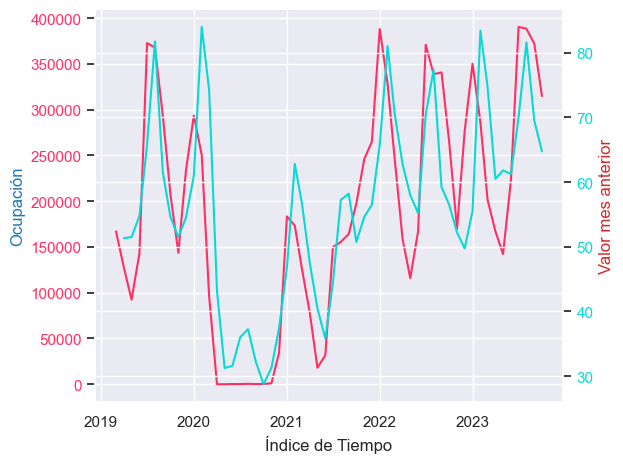

In [1283]:

# Filtrar el DataFrame para obtener solo las columnas relevantes
df_filtrado = union_con_trens[['indice_tiempo', 'pernoctes','ocupacion', 'valor','valor_mes_anterior','promedio_ultimos_4_valores','Mes','Año','valor_mes_año_anterior']]

# Configurar el gráfico
fig, ax1 = plt.subplots()

# Graficar la primera variable en el eje y izquierdo
color = 'tab:blue'
ax1.set_xlabel('Índice de Tiempo')
ax1.set_ylabel('Ocupación', color=color)
ax1.plot(df_filtrado['indice_tiempo'], df_filtrado['pernoctes'], color='#FF2E63')
ax1.tick_params(axis='y', labelcolor='#FF2E63')

# Crear un segundo eje y para la segunda variable
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Valor mes anterior', color=color)
ax2.plot(df_filtrado['indice_tiempo'], df_filtrado['valor_mes_anterior'], color='#08D9D6')
ax2.tick_params(axis='y', labelcolor='#08D9D6')

# Ajustar el diseño para evitar solapamiento
fig.tight_layout()

# Mostrar el gráfico
plt.show()


In [1284]:
df_filtrado['indice_tiempo']=pd.to_datetime(df_filtrado['indice_tiempo'])

In [1285]:
df_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   indice_tiempo               56 non-null     datetime64[ns]
 1   pernoctes                   56 non-null     float64       
 2   ocupacion                   56 non-null     float64       
 3   valor                       56 non-null     float64       
 4   valor_mes_anterior          55 non-null     float64       
 5   promedio_ultimos_4_valores  54 non-null     float64       
 6   Mes                         56 non-null     int32         
 7   Año                         56 non-null     int32         
 8   valor_mes_año_anterior      44 non-null     float64       
dtypes: datetime64[ns](1), float64(6), int32(2)
memory usage: 3.6 KB


In [1286]:
#df_filtrado.index = pd.PeriodIndex(df_filtrado.indice_tiempo, freq='M')
#df_filtrado["timeIndex"] = pd.Series(np.arange(len(df_filtrado['ocupacion'])), index=df_filtrado.index)

In [1287]:
df_filtrado.head(2)

,indice_tiempo,pernoctes,ocupacion,valor,valor_mes_anterior,promedio_ultimos_4_valores,Mes,Año,valor_mes_año_anterior
0,2019-03-01,166884.0,21.836510,51.333333,NaN,NaN,3,2019,NaN
1,2019-04-01,127177.0,17.195608,51.500000,51.333333,NaN,4,2019,NaN


In [1288]:
from statsmodels.tsa.seasonal import seasonal_decompose
ts=df_filtrado[['ocupacion']]
seasonality = 12 
result = seasonal_decompose(ts, model='additive', period=seasonality)
trend = result.trend
seasonal = result.seasonal
residual = result.resid

In [1289]:

#df_filtrado = df_filtrado.set_index('indice_tiempo')
#y = df_filtrado['ocupacion'].resample('MS').mean()

#import statsmodels.api as sm
#plt.figure(figsize=(16,10))
#decomposition = sm.tsa.seasonal_decompose(y, model='additive')
#decomposition.plot()
#plt.show()

In [1290]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Obtener la serie temporal promediada por mes
y = df_filtrado['ocupacion'].resample('MS').mean()

# Realizar la descomposición estacional
decomposition = sm.tsa.seasonal_decompose(y, model='additive')

# Crear la figura y los subgráficos
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(6, 6))

# Graficar la serie temporal original
axes[0].plot(decomposition.observed, color='#FF2E63')  # Cambiar el color a '#FF2E63'
axes[0].set_ylabel('Observed')

# Graficar la tendencia
axes[1].plot(decomposition.trend, color='#FF2E63')  # Cambiar el color a '#FF2E63'
axes[1].set_ylabel('Trend')

# Graficar la estacionalidad
axes[2].plot(decomposition.seasonal, color='#FF2E63')  # Cambiar el color a '#FF2E63'
axes[2].set_ylabel('Seasonal')

# Graficar los residuos como puntos
axes[3].scatter(decomposition.resid.index, decomposition.resid, color='#FF2E63', label='Residual', alpha=0.5)

# Calcular el valor medio de los residuos
resid_mean = decomposition.resid.mean()

# Graficar la línea horizontal para el valor medio de los residuos
axes[3].axhline(y=resid_mean, color='black', linestyle='--', linewidth=2, label='Residual Mean')

# Etiquetas y leyenda
axes[3].set_ylabel('Residual')
axes[3].legend()

# Ajustar el diseño
plt.tight_layout()

# Mostrar el gráfico
plt.show()



TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'RangeIndex'

Pernoctes vs promedio de valores de trens de ultimos 4 meses.

<Axes: xlabel='promedio_ultimos_4_valores', ylabel='pernoctes'>

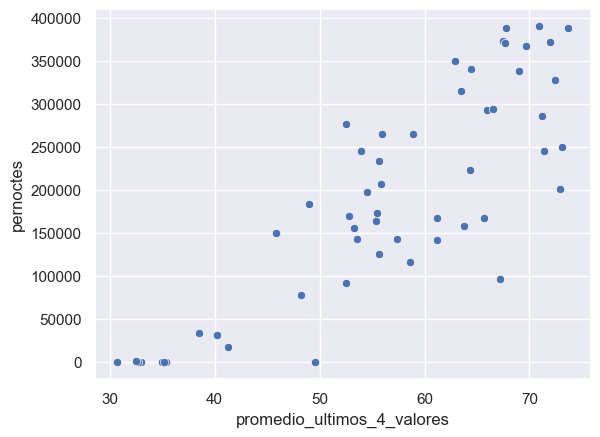

In [1291]:
sns.scatterplot(data=union_con_trens, y='pernoctes', x='promedio_ultimos_4_valores')

Pernoctes vs valor interes

<Axes: xlabel='valor', ylabel='pernoctes'>

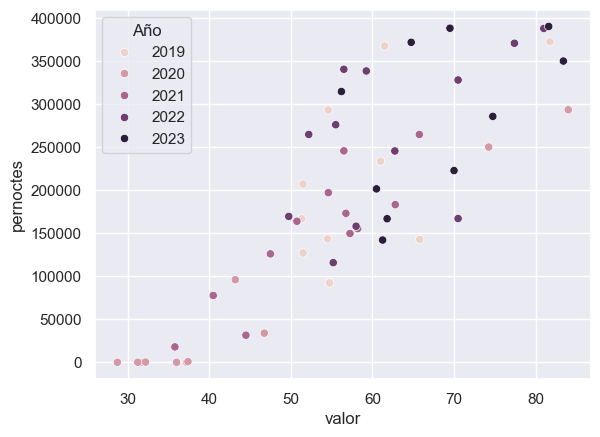

In [1292]:
sns.scatterplot(data=union_con_trens, y='pernoctes', x='valor',hue='Año')

Pernoctes vs valor interes mes anterior

<Axes: xlabel='valor_mes_anterior', ylabel='pernoctes'>

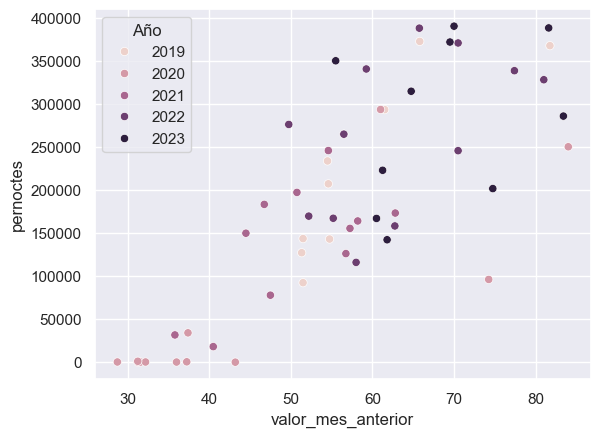

In [1293]:
sns.scatterplot(data=union_con_trens, y='pernoctes', x='valor_mes_anterior',hue='Año')

### MODELO DE PREDICCION DE PERNOCTES MENSUAL EN BARILOCHE

Hago dos copias del dataframe creado para poder ver la performance del modelo convirtiendo mes y año a dummies y sin convertir. 

In [1294]:
df=df_filtrado.copy()

In [1295]:
df.head(3)

,indice_tiempo,pernoctes,ocupacion,valor,valor_mes_anterior,promedio_ultimos_4_valores,Mes,Año,valor_mes_año_anterior
0,2019-03-01,166884.0,21.836510,51.333333,NaN,NaN,3,2019,NaN
1,2019-04-01,127177.0,17.195608,51.500000,51.333333,NaN,4,2019,NaN
2,2019-05-01,92354.0,12.084376,54.750000,51.500000,52.527778,5,2019,NaN


In [1296]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   indice_tiempo               56 non-null     datetime64[ns]
 1   pernoctes                   56 non-null     float64       
 2   ocupacion                   56 non-null     float64       
 3   valor                       56 non-null     float64       
 4   valor_mes_anterior          55 non-null     float64       
 5   promedio_ultimos_4_valores  54 non-null     float64       
 6   Mes                         56 non-null     int32         
 7   Año                         56 non-null     int32         
 8   valor_mes_año_anterior      44 non-null     float64       
dtypes: datetime64[ns](1), float64(6), int32(2)
memory usage: 3.6 KB


In [1297]:
df['Mes'] = df['Mes'].astype(str)
df['Año'] = df['Año'].astype(str)

In [1298]:
df = pd.get_dummies(df, columns=['Mes', 'Año'], prefix=['Mes', 'Año'], drop_first=True, dtype=int )

In [1299]:
df.head()

,indice_tiempo,pernoctes,ocupacion,valor,valor_mes_anterior,promedio_ultimos_4_valores,valor_mes_año_anterior,Mes_10,Mes_11,Mes_12,...,Mes_4,Mes_5,Mes_6,Mes_7,Mes_8,Mes_9,Año_2020,Año_2021,Año_2022,Año_2023
0,2019-03-01,166884.0,21.836510,51.333333,NaN,NaN,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2019-04-01,127177.0,17.195608,51.500000,51.333333,NaN,NaN,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2019-05-01,92354.0,12.084376,54.750000,51.500000,52.527778,NaN,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,2019-06-01,143065.0,19.343826,65.800000,54.750000,57.350000,NaN,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,2019-07-01,372696.0,48.766688,81.750000,65.800000,67.433333,NaN,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [1300]:
df.columns

Index(['indice_tiempo', 'pernoctes', 'ocupacion', 'valor',
       'valor_mes_anterior', 'promedio_ultimos_4_valores',
       'valor_mes_año_anterior', 'Mes_10', 'Mes_11', 'Mes_12', 'Mes_2',
       'Mes_3', 'Mes_4', 'Mes_5', 'Mes_6', 'Mes_7', 'Mes_8', 'Mes_9',
       'Año_2020', 'Año_2021', 'Año_2022', 'Año_2023'],
      dtype='object')

In [1301]:
df = pd.concat([df, df_filtrado[['Año', 'Mes']]], axis=1)

In [1302]:
df.head(3)

,indice_tiempo,pernoctes,ocupacion,valor,valor_mes_anterior,promedio_ultimos_4_valores,valor_mes_año_anterior,Mes_10,Mes_11,Mes_12,...,Mes_6,Mes_7,Mes_8,Mes_9,Año_2020,Año_2021,Año_2022,Año_2023,Año,Mes
0,2019-03-01,166884.0,21.836510,51.333333,NaN,NaN,NaN,0,0,0,...,0,0,0,0,0,0,0,0,2019,3
1,2019-04-01,127177.0,17.195608,51.500000,51.333333,NaN,NaN,0,0,0,...,0,0,0,0,0,0,0,0,2019,4
2,2019-05-01,92354.0,12.084376,54.750000,51.500000,52.527778,NaN,0,0,0,...,0,0,0,0,0,0,0,0,2019,5


In [1303]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
import optuna

### 1. Regresion Lineal

In [1304]:

# Ordenar por 'indice_tiempo'
df = df.sort_values(by='indice_tiempo')

# Imputar valores nulos
# df = df.fillna(0)  # Puedes usar diferentes estrategias para imputar valores nulos según tus necesidades

# Definir las features (X) y la target (y)
features = ['valor']
target = ['pernoctes']

X = df[features]
y = df[target]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)

# Inicializar el modelo de regresión lineal
model = LinearRegression()

# Entrenar el modelo
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el rendimiento del modelo
mse = mean_squared_error(y_test, y_pred)
r2=r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'r2: {r2}')
# Imprimir los coeficientes del modelo
print('Coeficientes del modelo:')
for feature, coef in zip(features, model.coef_):
    print(f'{feature}: {coef}')

# Imprimir el intercepto del modelo
print(f'Intercepto del modelo: {model.intercept_}')


Mean Squared Error: 5984627430.247975
r2: 0.21393572682430595
Coeficientes del modelo:
valor: [7227.26185802]
Intercepto del modelo: [-223728.55140797]


### 2. Arbol de Decisión 

        Real  Predicción
44  169688.0    143574.0
45  276215.0    143574.0
46  350187.0    183343.0
47  285907.0    328164.0
48  201686.0     96118.0
49  167006.0    158266.0
50  142228.0    158266.0
51  222950.0    340647.0
52  390398.0    370874.0
53  388352.0    338663.0
54  371970.0    338663.0
55  314773.0    338663.0


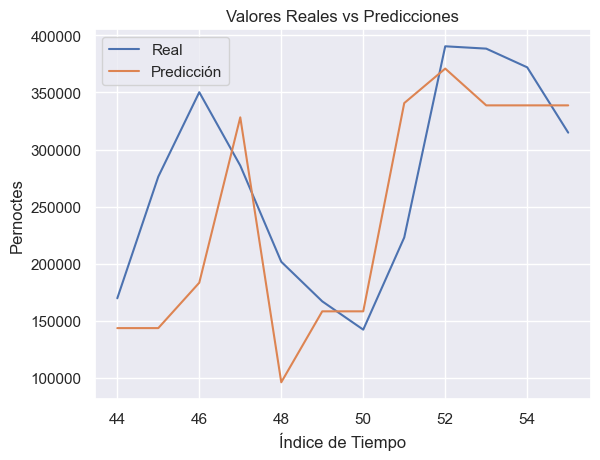

Mean Squared Error: 6479934448.75
r2: 0.1488785188300764


In [1305]:


# Ordenar por 'indice_tiempo'
df = df.sort_values(by='indice_tiempo')

# Imputar valores nulos
df = df.fillna(0)  # Puedes usar diferentes estrategias para imputar valores nulos según tus necesidades

# Definir las features (X) y la target (y)
features = ['valor_mes_anterior','Mes','Año']
target = 'pernoctes'

X = df[features]
y = df[target]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Inicializar el modelo de árbol de decisión
model = DecisionTreeRegressor()

# Entrenar el modelo
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Mostrar los valores reales y las predicciones
results_df = pd.DataFrame({'Real': y_test, 'Predicción': y_pred})
print(results_df)

# Graficar los resultados
plt.plot(results_df.index, results_df['Real'], label='Real')
plt.plot(results_df.index, results_df['Predicción'], label='Predicción')
plt.xlabel('Índice de Tiempo')
plt.ylabel('Pernoctes')
plt.title('Valores Reales vs Predicciones')
plt.legend()
plt.show()

# Evaluar el rendimiento del modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'r2: {r2}')



### 3. Arbol de Decisión con Dummies

In [1306]:
df2 = df2.fillna(0)
features = ['valor_mes_anterior',
        'Mes_10', 'Mes_11', 'Mes_12', 'Mes_2', 'Mes_3', 'Mes_4',
       'Mes_5', 'Mes_6', 'Mes_7', 'Mes_8', 'Mes_9', 'Año_2020',
       'Año_2021', 'Año_2022', 'Año_2023']
target = 'pernoctes'

X = df2[features]
y = df2[target]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Inicializar el modelo de árbol de decisión
model = DecisionTreeRegressor()

# Entrenar el modelo
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el rendimiento del modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'r2: {r2}')

NameError: name 'df2' is not defined

### 4. Modelos de Ensamble XGBoostRegressor

#### XGBoostRegressor con dummies

[I 2024-03-15 09:55:57,142] A new study created in memory with name: no-name-4adedcf8-85c5-4b95-a52e-39cf9b39c83e
/var/folders/n9/fw43flpn4k74bk1f25xmgj340000gn/T/ipykernel_12282/3864557736.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
/var/folders/n9/fw43flpn4k74bk1f25xmgj340000gn/T/ipykernel_12282/3864557736.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
[I 2024-03-15 09:55:57,190] Trial 0 finished with value: -0.24963158084741832 and parameters: {'booster': 'gbtree', 'lambda': 0.001764519065232934, 'alpha': 0.49277589006820177, 'colsample_bytre

Mejores hiperparámetros: {'booster': 'gblinear', 'lambda': 3.6472849712301855e-08, 'alpha': 3.367127111076489e-06, 'colsample_bytree': 0.26439759815829056, 'subsample': 0.37131357721604363, 'learning_rate': 0.29916246369533395, 'n_estimators': 285, 'max_depth': 4, 'min_child_weight': 8}
Mejor valor de r2: 0.6554829650268236
        Real     Predicción
44  169688.0  231218.093750
45  276215.0  261207.765625
46  350187.0  355077.187500
47  285907.0  343876.718750
48  201686.0  282066.000000
49  167006.0  171316.828125
50  142228.0  157504.718750
51  222950.0  187653.781250
52  390398.0  322354.437500
53  388352.0  321336.281250
54  371970.0  301143.625000
55  314773.0  270055.406250


/Users/silvinademicco/anaconda3/envs/silvina2024/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [09:56:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "colsample_bytree", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)


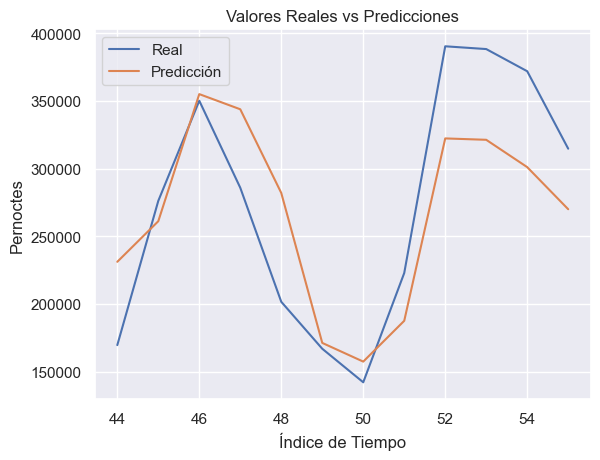

Mean Squared Error: 2624281010.237345
r2: 0.6553079420625655


In [1307]:



# Definir las features (X) y la target (y)
features = ['valor_mes_anterior', 'Mes_10', 'Mes_11', 'Mes_12', 'Mes_2', 'Mes_3', 'Mes_4',
       'Mes_5', 'Mes_6', 'Mes_7', 'Mes_8', 'Mes_9', 'Año_2020',
       'Año_2021', 'Año_2022', 'Año_2023']
target = 'pernoctes'

X = df[features]
y = df[target]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'random_state': 42
    }

    model = xgb.XGBRegressor(**params)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    return r2

# Crear un estudio de Optuna y ejecutar la optimización
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Imprimir los resultados de la optimización
print('Mejores hiperparámetros:', study.best_params)
print('Mejor valor de r2:', study.best_value)

# Obtener el modelo con los mejores hiperparámetros
best_params = study.best_params
best_model = xgb.XGBRegressor(**best_params)

# Entrenar el modelo con todos los datos de entrenamiento
best_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Mostrar los valores reales y las predicciones
results_df = pd.DataFrame({'Real': y_test, 'Predicción': y_pred})
print(results_df)

# Graficar los resultados
plt.plot(results_df.index, results_df['Real'], label='Real')
plt.plot(results_df.index, results_df['Predicción'], label='Predicción')
plt.xlabel('Índice de Tiempo')
plt.ylabel('Pernoctes')
plt.title('Valores Reales vs Predicciones')
plt.legend()
plt.show()

# Evaluar el rendimiento del modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'r2: {r2}')


#### XGBoostRegressor sin dummies

[I 2024-03-15 09:56:10,771] A new study created in memory with name: no-name-970cc2e0-ef97-4b7b-944b-654694dab4e8
/var/folders/n9/fw43flpn4k74bk1f25xmgj340000gn/T/ipykernel_12282/2591902506.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
/var/folders/n9/fw43flpn4k74bk1f25xmgj340000gn/T/ipykernel_12282/2591902506.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
/Users/silvinademicco/anaconda3/envs/silvina2024/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [09:56:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parame

Mejores hiperparámetros: {'booster': 'gbtree', 'lambda': 1.814112243517288e-07, 'alpha': 2.2628328111133936e-05, 'colsample_bytree': 0.733209405422771, 'subsample': 0.9376020886555342, 'learning_rate': 0.23132693526334458, 'n_estimators': 295, 'max_depth': 8, 'min_child_weight': 3}
Mejor valor de r2: 0.917602540784463
        Real     Predicción
44  169688.0  199457.859375
45  276215.0  233047.671875
46  350187.0  290987.812500
47  285907.0  328147.812500
48  201686.0  212133.312500
49  167006.0  169630.359375
50  142228.0  210956.062500
51  222950.0  233947.703125
52  390398.0  394004.468750
53  388352.0  375196.437500
54  371970.0  390245.343750
55  314773.0  343936.718750


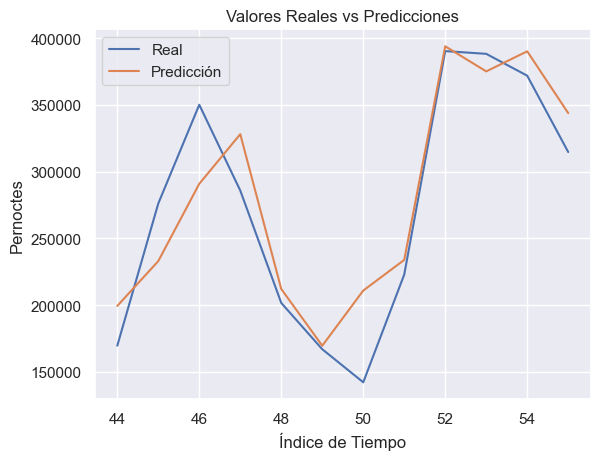

Mean Squared Error: 1197467379.8046875
r2: 0.8427159691177681


In [1308]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import optuna

# Ordenar por 'indice_tiempo'
df = df.sort_values(by='indice_tiempo')

# Imputar valores nulos
df = df.dropna()
# Definir las features (X) y la target (y)
features = ['valor_mes_anterior','Mes','Año']
target = 'pernoctes'

X = df[features]
y = df[target]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'random_state': 42
    }

    model = xgb.XGBRegressor(**params)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    return r2

# Crear un estudio de Optuna y ejecutar la optimización
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Imprimir los resultados de la optimización
print('Mejores hiperparámetros:', study.best_params)
print('Mejor valor de r2:', study.best_value)

# Obtener el modelo con los mejores hiperparámetros
best_params = study.best_params
best_model = xgb.XGBRegressor(**best_params)

# Entrenar el modelo con todos los datos de entrenamiento
best_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Mostrar los valores reales y las predicciones
results_df = pd.DataFrame({'Real': y_test, 'Predicción': y_pred})
print(results_df)

# Graficar los resultados
plt.plot(results_df.index, results_df['Real'], label='Real')
plt.plot(results_df.index, results_df['Predicción'], label='Predicción')
plt.xlabel('Índice de Tiempo')
plt.ylabel('Pernoctes')
plt.title('Valores Reales vs Predicciones')
plt.legend()
plt.show()

# Evaluar el rendimiento del modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'r2: {r2}')

In [1309]:
X_train

,valor_mes_anterior,Mes,Año
0,0.000000,3,2019
1,51.333333,4,2019
2,51.500000,5,2019
3,54.750000,6,2019
4,65.800000,7,2019
5,81.750000,8,2019
6,61.500000,9,2019
7,54.600000,10,2019
8,51.500000,11,2019
9,54.500000,12,2019


[I 2024-03-15 10:03:03,786] A new study created in memory with name: no-name-e3e293ab-345d-43a7-b7d5-f664fb53f3ae
/var/folders/n9/fw43flpn4k74bk1f25xmgj340000gn/T/ipykernel_12282/1715602482.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
/var/folders/n9/fw43flpn4k74bk1f25xmgj340000gn/T/ipykernel_12282/1715602482.py:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
[I 2024-03-15 10:03:03,903] Trial 0 finished with value: 0.5247029838529433 and parameters: {'booster': 'dart', 'lambda': 1.0796613360612046e-06, 'alpha': 0.0916010550716876, 'colsample_bytree':

Mejores hiperparámetros: {'booster': 'gbtree', 'lambda': 0.06624459181208711, 'alpha': 2.8330668722414437e-05, 'colsample_bytree': 0.7817817039938236, 'subsample': 0.4453798800275408, 'learning_rate': 0.16664697464837547, 'n_estimators': 252, 'max_depth': 15, 'min_child_weight': 1}
Mejor valor de r2: 0.6914747679179386
        Real     Predicción
44  169688.0  244829.281250
45  276215.0  292622.406250
46  350187.0  386264.281250
47  285907.0  351365.531250
48  201686.0  240118.718750
49  167006.0  180597.765625
50  142228.0  160965.312500
51  222950.0  181130.015625
52  390398.0  303654.468750
53  388352.0  319425.437500
54  371970.0  298467.250000
55  314773.0  258632.062500


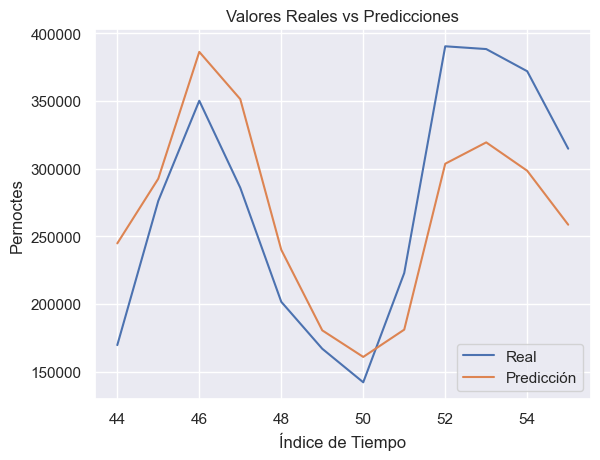

Mean Squared Error: 3007781912.7033286
r2: 0.6049361584097517


In [1311]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import optuna

# Ordenar por 'indice_tiempo'
df = df.sort_values(by='indice_tiempo')

# Imputar valores nulos
df = df.dropna()

# Definir las features (X) y la target (y)
#features = ['valor_mes_anterior', 'Mes','Año']
features = ['Mes','Año']
target = 'pernoctes'

X = df[features]
y = df[target]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'random_state': 42
    }

    model = xgb.XGBRegressor(**params)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    return r2

# Crear un estudio de Optuna y ejecutar la optimización
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Imprimir los resultados de la optimización
print('Mejores hiperparámetros:', study.best_params)
print('Mejor valor de r2:', study.best_value)

# Obtener el modelo con los mejores hiperparámetros
best_params = study.best_params
best_model = xgb.XGBRegressor(**best_params)

# Entrenar el modelo con todos los datos de entrenamiento
best_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Mostrar los valores reales y las predicciones
results_df = pd.DataFrame({'Real': y_test, 'Predicción': y_pred})
print(results_df)

# Graficar los resultados
plt.plot(results_df.index, results_df['Real'], label='Real')
plt.plot(results_df.index, results_df['Predicción'], label='Predicción')
plt.xlabel('Índice de Tiempo')
plt.ylabel('Pernoctes')
plt.title('Valores Reales vs Predicciones')
plt.legend()
plt.show()

# Evaluar el rendimiento del modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'r2: {r2}')

### Elijo el ultimo modelos de XGBoost sin dummies (como son pocos datos al aplicar dummies se pierde informacion)
Obtengo los valores de residuos para determinar el intervalo de confianza de la prediccion del modelo con un nivel de significancia de 0.05.

In [1168]:

# Obtener predicciones y residuos en el conjunto de prueba
predicciones = best_model.predict(X_test)
residuos = y_test - predicciones

# Calcular desviación estándar de los residuos en el conjunto de prueba
desviacion_estandar_test = np.std(residuos)

# Construir intervalo de confianza del 95%
intervalo_confianza_test = 1.96 * desviacion_estandar_test
limite_superior_test = predicciones + intervalo_confianza_test
limite_inferior_test = predicciones - intervalo_confianza_test




In [1169]:
print(intervalo_confianza_test)

121692.1635062871


Para estar segura que esta ok aplicar el criterio anterior de intervalo de confianza verifico que los residuos sigan una distribucion normal aplicando la prueba de normalidad de Shapiro-Wilk

Predicción: 324589.5, Intervalo de confianza (Test): (226653.171875, 422525.8125)
Predicción: 258852.15625, Intervalo de confianza (Test): (160915.828125, 356788.5)
Predicción: 402746.625, Intervalo de confianza (Test): (304810.3125, 500682.9375)
Predicción: 327607.25, Intervalo de confianza (Test): (229670.921875, 425543.5625)
Predicción: 246124.09375, Intervalo de confianza (Test): (148187.765625, 344060.4375)
Predicción: 154686.421875, Intervalo de confianza (Test): (56750.09375, 252622.75)
Predicción: 169164.796875, Intervalo de confianza (Test): (71228.46875, 267101.125)
Predicción: 226497.171875, Intervalo de confianza (Test): (128560.84375, 324433.5)
Predicción: 407830.25, Intervalo de confianza (Test): (309893.9375, 505766.5625)
Predicción: 369612.25, Intervalo de confianza (Test): (271675.9375, 467548.5625)
Predicción: 337159.96875, Intervalo de confianza (Test): (239223.640625, 435096.3125)


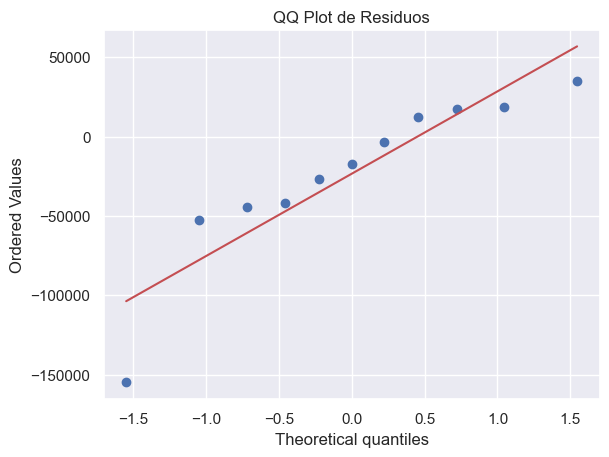

Prueba de Shapiro-Wilk - Estadístico: 0.854784101500729, Valor p: 0.04926476148747413
Los residuos no parecen seguir una distribución normal (p <= 0.05)


In [1157]:
from scipy.stats import shapiro, probplot
for i in range(len(X_test)):
    print(f"Predicción: {predicciones[i]}, Intervalo de confianza (Test): ({limite_inferior_test[i]}, {limite_superior_test[i]})")

# Graficar el QQ plot
probplot(residuos, dist="norm", plot=plt)
plt.title('QQ Plot de Residuos')
plt.show()

# Prueba de normalidad de Shapiro-Wilk
shapiro_test_statistic, shapiro_p_value = shapiro(residuos)
print(f"Prueba de Shapiro-Wilk - Estadístico: {shapiro_test_statistic}, Valor p: {shapiro_p_value}")

# Interpretar los resultados
alpha = 0.05
if shapiro_p_value > alpha:
    print("Los residuos parecen seguir una distribución normal (p > 0.05)")
else:
    print("Los residuos no parecen seguir una distribución normal (p <= 0.05)")

Creo un grafico con los valores reales, las predicciones y los intervalos de confiaza. 

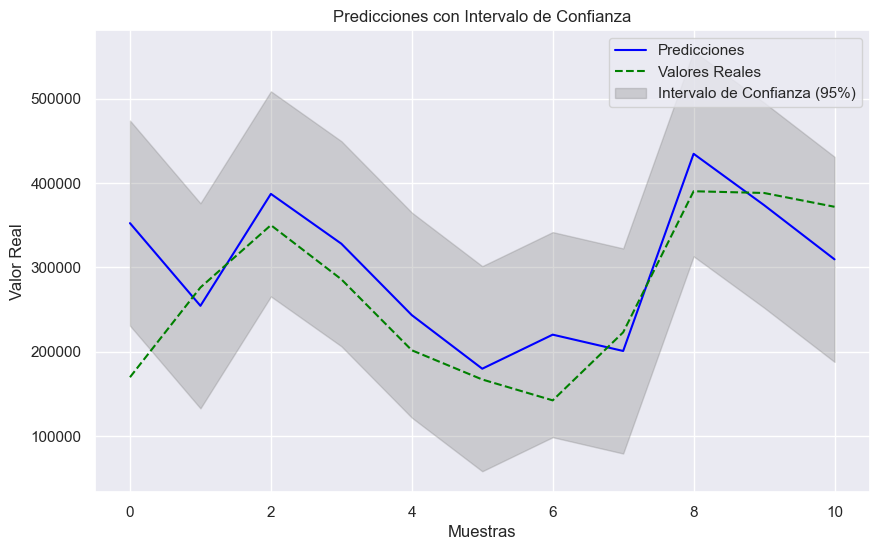

In [1170]:
# Crear un gráfico
plt.figure(figsize=(10, 6))

# Graficar las predicciones
plt.plot(predicciones, label='Predicciones', color='blue')
# Graficar los valores reales
plt.plot(y_test.values, label='Valores Reales', color='green', linestyle='--')

# Graficar el intervalo de confianza en gris
plt.fill_between(range(len(y_test)), limite_inferior_test, limite_superior_test, color='gray', alpha=0.3, label='Intervalo de Confianza (95%)')

# Añadir etiquetas y leyenda
plt.xlabel('Muestras')
plt.ylabel('Valor Real')
plt.title('Predicciones con Intervalo de Confianza')
plt.legend()

# Mostrar el gráfico
plt.show()


Guardo el modelo para luego tomarlo en la app streamlit

In [1159]:
#best_model.save_model('xgb_model_turismo_6.json')

In [1160]:
X_test_final = pd.concat([X_test, results_df['Predicción']], axis=1)

In [1161]:
X_test_final = pd.concat([X_test_final, results_df['Real']], axis=1)

In [1162]:
X_test_final 

,valor_mes_anterior,Mes,Año,Predicción,Real
44,38.20,11,2022,324589.500000,169688.0
45,29.50,12,2022,258852.156250,276215.0
46,43.50,1,2023,402746.625000,350187.0
47,84.20,2,2023,327607.250000,285907.0
48,56.25,3,2023,246124.093750,201686.0
49,35.75,4,2023,154686.421875,167006.0
50,39.40,5,2023,169164.796875,142228.0
51,35.00,6,2023,226497.171875,222950.0
52,46.00,7,2023,407830.250000,390398.0
53,47.40,8,2023,369612.250000,388352.0


In [1163]:
X_test_final['Fecha'] = X_test_final['Mes'].astype(str) + '/' + X_test_final['Año'].astype(str)
X_test_final['Fecha'] = pd.to_datetime(X_test_final['Fecha'], format='%m/%Y')

In [1164]:
valores_reales=X_test_final[['Fecha','Mes','Año','Real','valor_mes_anterior']]

In [ ]:
dic_mes ={
    1: 31,
    2: 28,
    3: 31,
    4: 30,
    5: 31,
    6: 30,
    7: 31,
    8: 31,
    9: 30,
    10: 31,
    11: 30,
    12: 31
}

In [1101]:
valores_reales['cantidad_dias']=valores_reales['Mes'].replace(dic_mes)

In [1102]:
valores_reales['total_plazas_mes']=valores_reales['cantidad_dias']*24653


In [1103]:
valores_reales['ocupacion_real']=(valores_reales['Real']/valores_reales['total_plazas_mes'])*100


In [1104]:
valores_reales

,Fecha,Mes,Año,Real,valor_mes_anterior,cantidad_dias,total_plazas_mes,ocupacion_real
44,2022-11-01,11,2022,169688.0,38.20,30,739590,22.943523
45,2022-12-01,12,2022,276215.0,29.50,31,764243,36.142300
46,2023-01-01,1,2023,350187.0,43.50,31,764243,45.821421
47,2023-02-01,2,2023,285907.0,84.20,28,690284,41.418749
48,2023-03-01,3,2023,201686.0,56.25,31,764243,26.390297
49,2023-04-01,4,2023,167006.0,35.75,30,739590,22.580889
50,2023-05-01,5,2023,142228.0,39.40,31,764243,18.610311
51,2023-06-01,6,2023,222950.0,35.00,30,739590,30.145080
52,2023-07-01,7,2023,390398.0,46.00,31,764243,51.082967
53,2023-08-01,8,2023,388352.0,47.40,31,764243,50.815251


In [ ]:
#valores_reales.to_csv('valores_reales')

NameError: name 'valores_reales' is not defined

In [ ]:
X_test_final['Fecha'] = X_test_final['Mes'].astype(str) + '/' + X_test_final['Año'].astype(str)


NameError: name 'X_test_final' is not defined

In [ ]:
X_test_final['Fecha'] = pd.to_datetime(X_test_final['Fecha'], format='%m/%Y')

NameError: name 'X_test_final' is not defined

In [ ]:
X_test_final

NameError: name 'X_test_final' is not defined